# Setup

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet scrnatools

In [1]:
import scrnatools as rna
import string
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import random
import os
import shutil

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
rna.configs.verbosity = "info"

# Import data

Downloads and loads the 3k pbmc example dataset provided with scanpy <br>
Otherwise import your own datasets folling the documentation at https://scanpy.readthedocs.io/en/latest/api.html#reading

In [3]:
adata = sc.datasets.pbmc3k()
# Store the raw counts data in a layer
adata.layers["raw_counts"] = adata.X.copy()
# FOR DEMO ONLY
# This sample data is human so gene names are capitalized, but immgen data for cell type similarity is from mouse so gene names only have first letter capitalized
# For real data analysis, do not do this, use a human reference for similarity scoring instead
adata.var_names = [string.capwords(i) for i in adata.var_names]
adata.var_names_make_unique()

In [4]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    layers: 'raw_counts'

# Doublet removal

Uses scrublet (https://github.com/swolock/scrublet) to filter out potential doublets in each batch

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 41.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.6%
Elapsed time: 1.5 seconds
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 48.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.6%


2022-07-18 22:04:11 - scrublet - INFO: 2.222% of cells classified as doublets (60 cells)


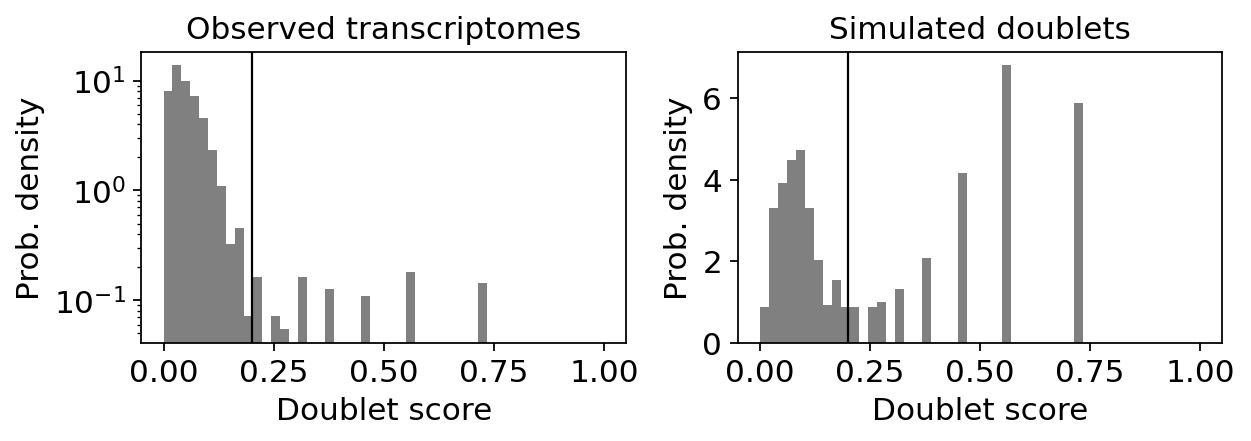

In [5]:
adata = rna.qc.scrublet(
    adata,
    doublet_threshold = 0.2, # Score threshold to use to call doublets
    batch_key = None, # Use batch information from a column in 'adata.obs' to run scrublet on each batch independently
    raw_counts_layer = "raw_counts" # use the raw counts data
)

In [6]:
adata

AnnData object with n_obs × n_vars = 2640 × 32738
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet'
    var: 'gene_ids'
    layers: 'raw_counts'

# Preprocessing

## Get QC metrics using scanpy

In [7]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

## Filter cells based on QC metrics

2022-07-18 22:04:12 - qc_plotting - INFO: Saving figure to analysis/qc_plots.png


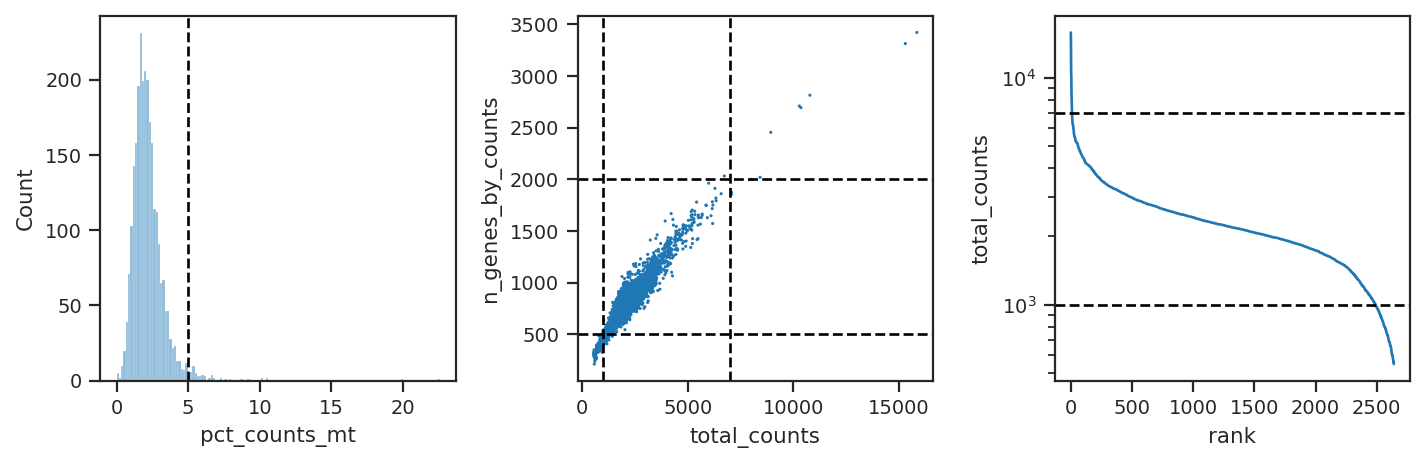

In [8]:
counts_thresholds=(1000, 7000) # The lower and upper total_counts thresholds
genes_thresholds=(500, 2000) # The lower and upper n_genes_by_counts thresholds
mt_threshold=5 # The pct_counts_mt threshold

rna.pl.qc_plotting(
    adata,
    counts_thresholds=counts_thresholds,
    genes_thresholds=genes_thresholds,
    mt_threshold=mt_threshold,
    show_thresholds=True, # Whether to show the thresholds on the figure
    batch_key=None, # Batch keys in adata.obs to plot seperately
    show_legend=False, # Whether to show the batch key legend
    figsize=(9, 3),
    dpi=300,
    save_path="analysis/qc_plots.png",
)

2022-07-18 22:04:12 - filter_cells - INFO: Number of cells before QC filtering: 2640
2022-07-18 22:04:12 - filter_cells - INFO: Number of cells after QC filtering: 2385
2022-07-18 22:04:12 - qc_plotting - INFO: Saving figure to analysis/filtered_qc_plots.png


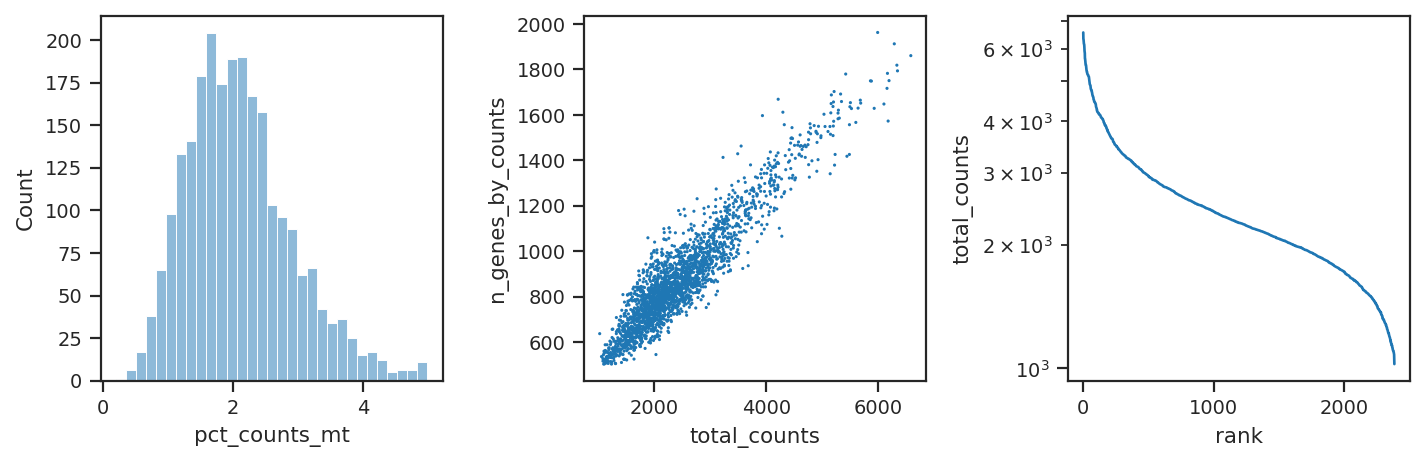

In [9]:
filteredAdata = rna.qc.filter_cells(
    adata,
    counts_thresholds=counts_thresholds, # The lower and upper total_counts thresholds
    genes_thresholds=genes_thresholds, # The lower and upper n_genes_by_counts thresholds
    mt_threshold=mt_threshold, # The pct_counts_mt threshold
)
rna.pl.qc_plotting(
    filteredAdata,
    show_thresholds=False,
    save_path="analysis/filtered_qc_plots.png",
)

In [10]:
# Once you're happy with qc cell filtering, overwrite adata with the filtered adata
adata = filteredAdata
del filteredAdata

## Log transform data with scanpy

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

## Subset genes

This step is recommended, but some analysis can be done using all genes instead of filtering genes by absolute expression or variability of expression

In [12]:
# Subset on highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200, # Number of HVGs to keep
    subset=True, # Subset the adata in place
    layer="raw_counts", # Use the raw counts data for calculations
    flavor="seurat_v3", # HVG algorithm to use
    batch_key=None, # Column in adata.obs that annotates batches of data
)

# Or subset on genes above minimum average expression threshold
# adata = adata[:, adata.var.mean_counts > 0.01].copy()

In [13]:
adata

AnnData object with n_obs × n_vars = 2385 × 1200
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'qc_plot_batch'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_counts'

## Normalize data with scanpy

This step is optional for use when downstream analysis is done within scanpy, otherwise scVI normalization can be done on its own

In [14]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
# Scanpy normalized expression is now stored in adata.X

## Normalize data with scVI

In [15]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw_counts",
    batch_key=None,
)
model = scvi.model.SCVI(adata)

In [16]:
# Train scVI model - run on google colab with a GPU session or a Windows machine with an Nvidia GPU
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 400/400: 100%|██████████| 400/400 [01:10<00:00,  5.69it/s, loss=406, v_num=1]


In [17]:
if not os.path.isdir("data/scVI_models"):
    os.makedirs("data/scVI_models")
if os.path.isdir("data/scVI_models"):
    shutil.rmtree("data/scVI_models")
# save the scVI model and adata object before further processing because training is non-deterministic
model.save("data/scVI_models/pbmc_3k_1200_hvgs")
adata.write("data/pbmc_3k_1200_hvgs.h5ad")

In [3]:
# To reload saved adata/scVI model later:
adata = sc.read("data/pbmc_3k_1200_hvgs.h5ad")
model = scvi.model.SCVI.load("data/scVI_models/pbmc_3k_1200_hvgs", adata=adata)

INFO     File data/scVI_models/pbmc_3k_1200_hvgs/model.pt already downloaded                 


In [19]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [20]:
adata

AnnData object with n_obs × n_vars = 2385 × 1200
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'qc_plot_batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_scVI'
    layers: 'raw_counts', 'scVI_normalized'

# Dimensionality reduction

## UMAP

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


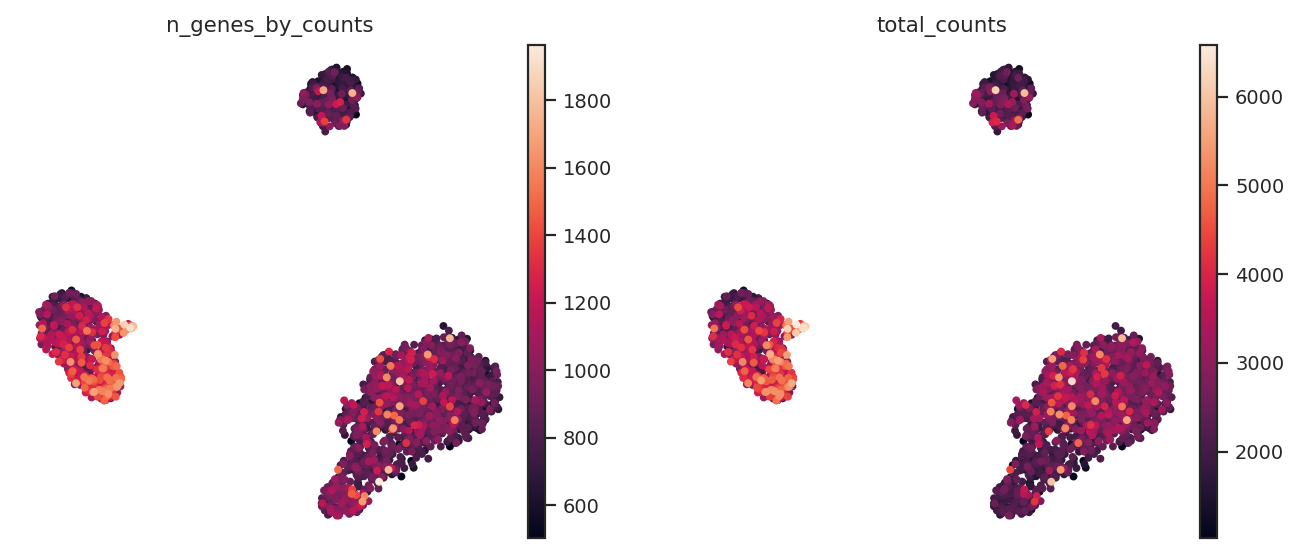

In [21]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
# Check dimensionality reduction (look for batch effects here if applicable)
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts"],
)

## TSNE

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


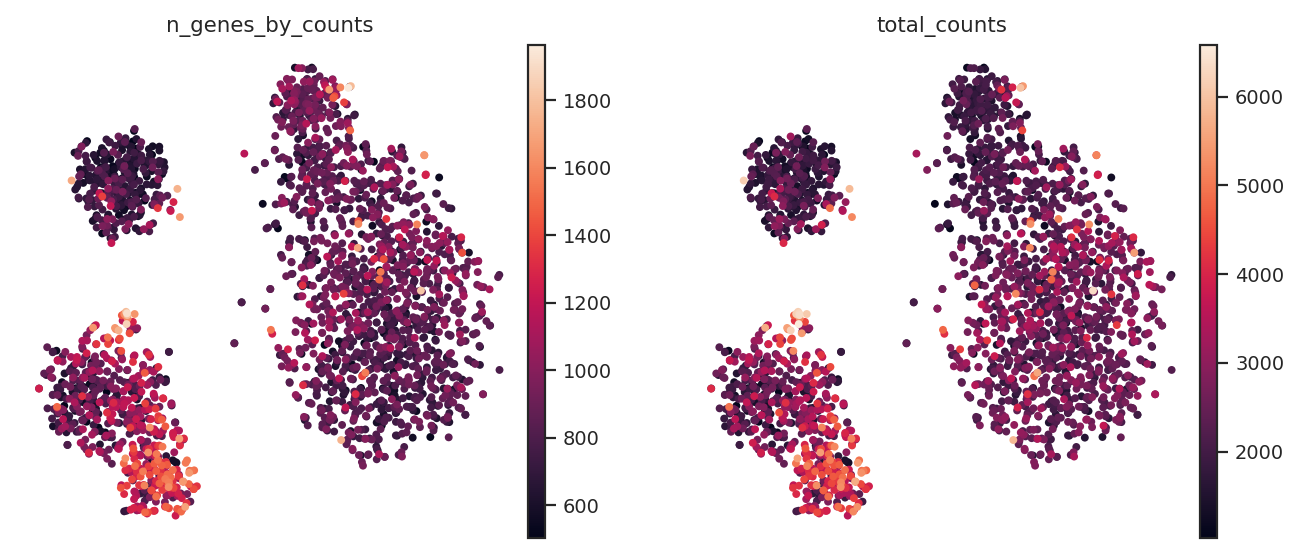

In [22]:
sc.tl.tsne(adata, use_rep="X_scVI")
# Check dimensionality reduction (look for batch effects here if applicable)
sc.pl.tsne(
    adata,
    color=["n_genes_by_counts", "total_counts"],
)

# Clustering

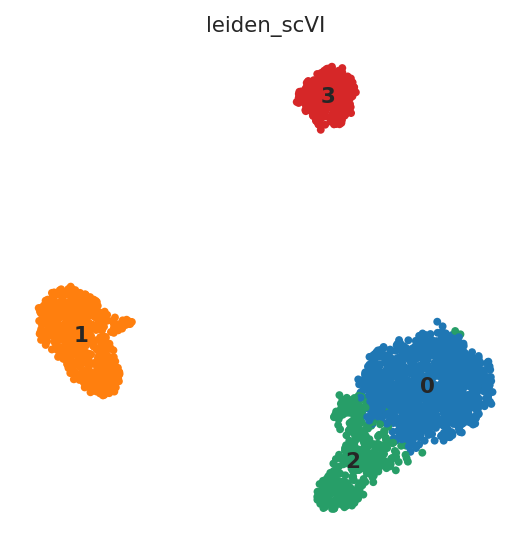

In [23]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
)

# Plot genes

## UMAP/TSNE

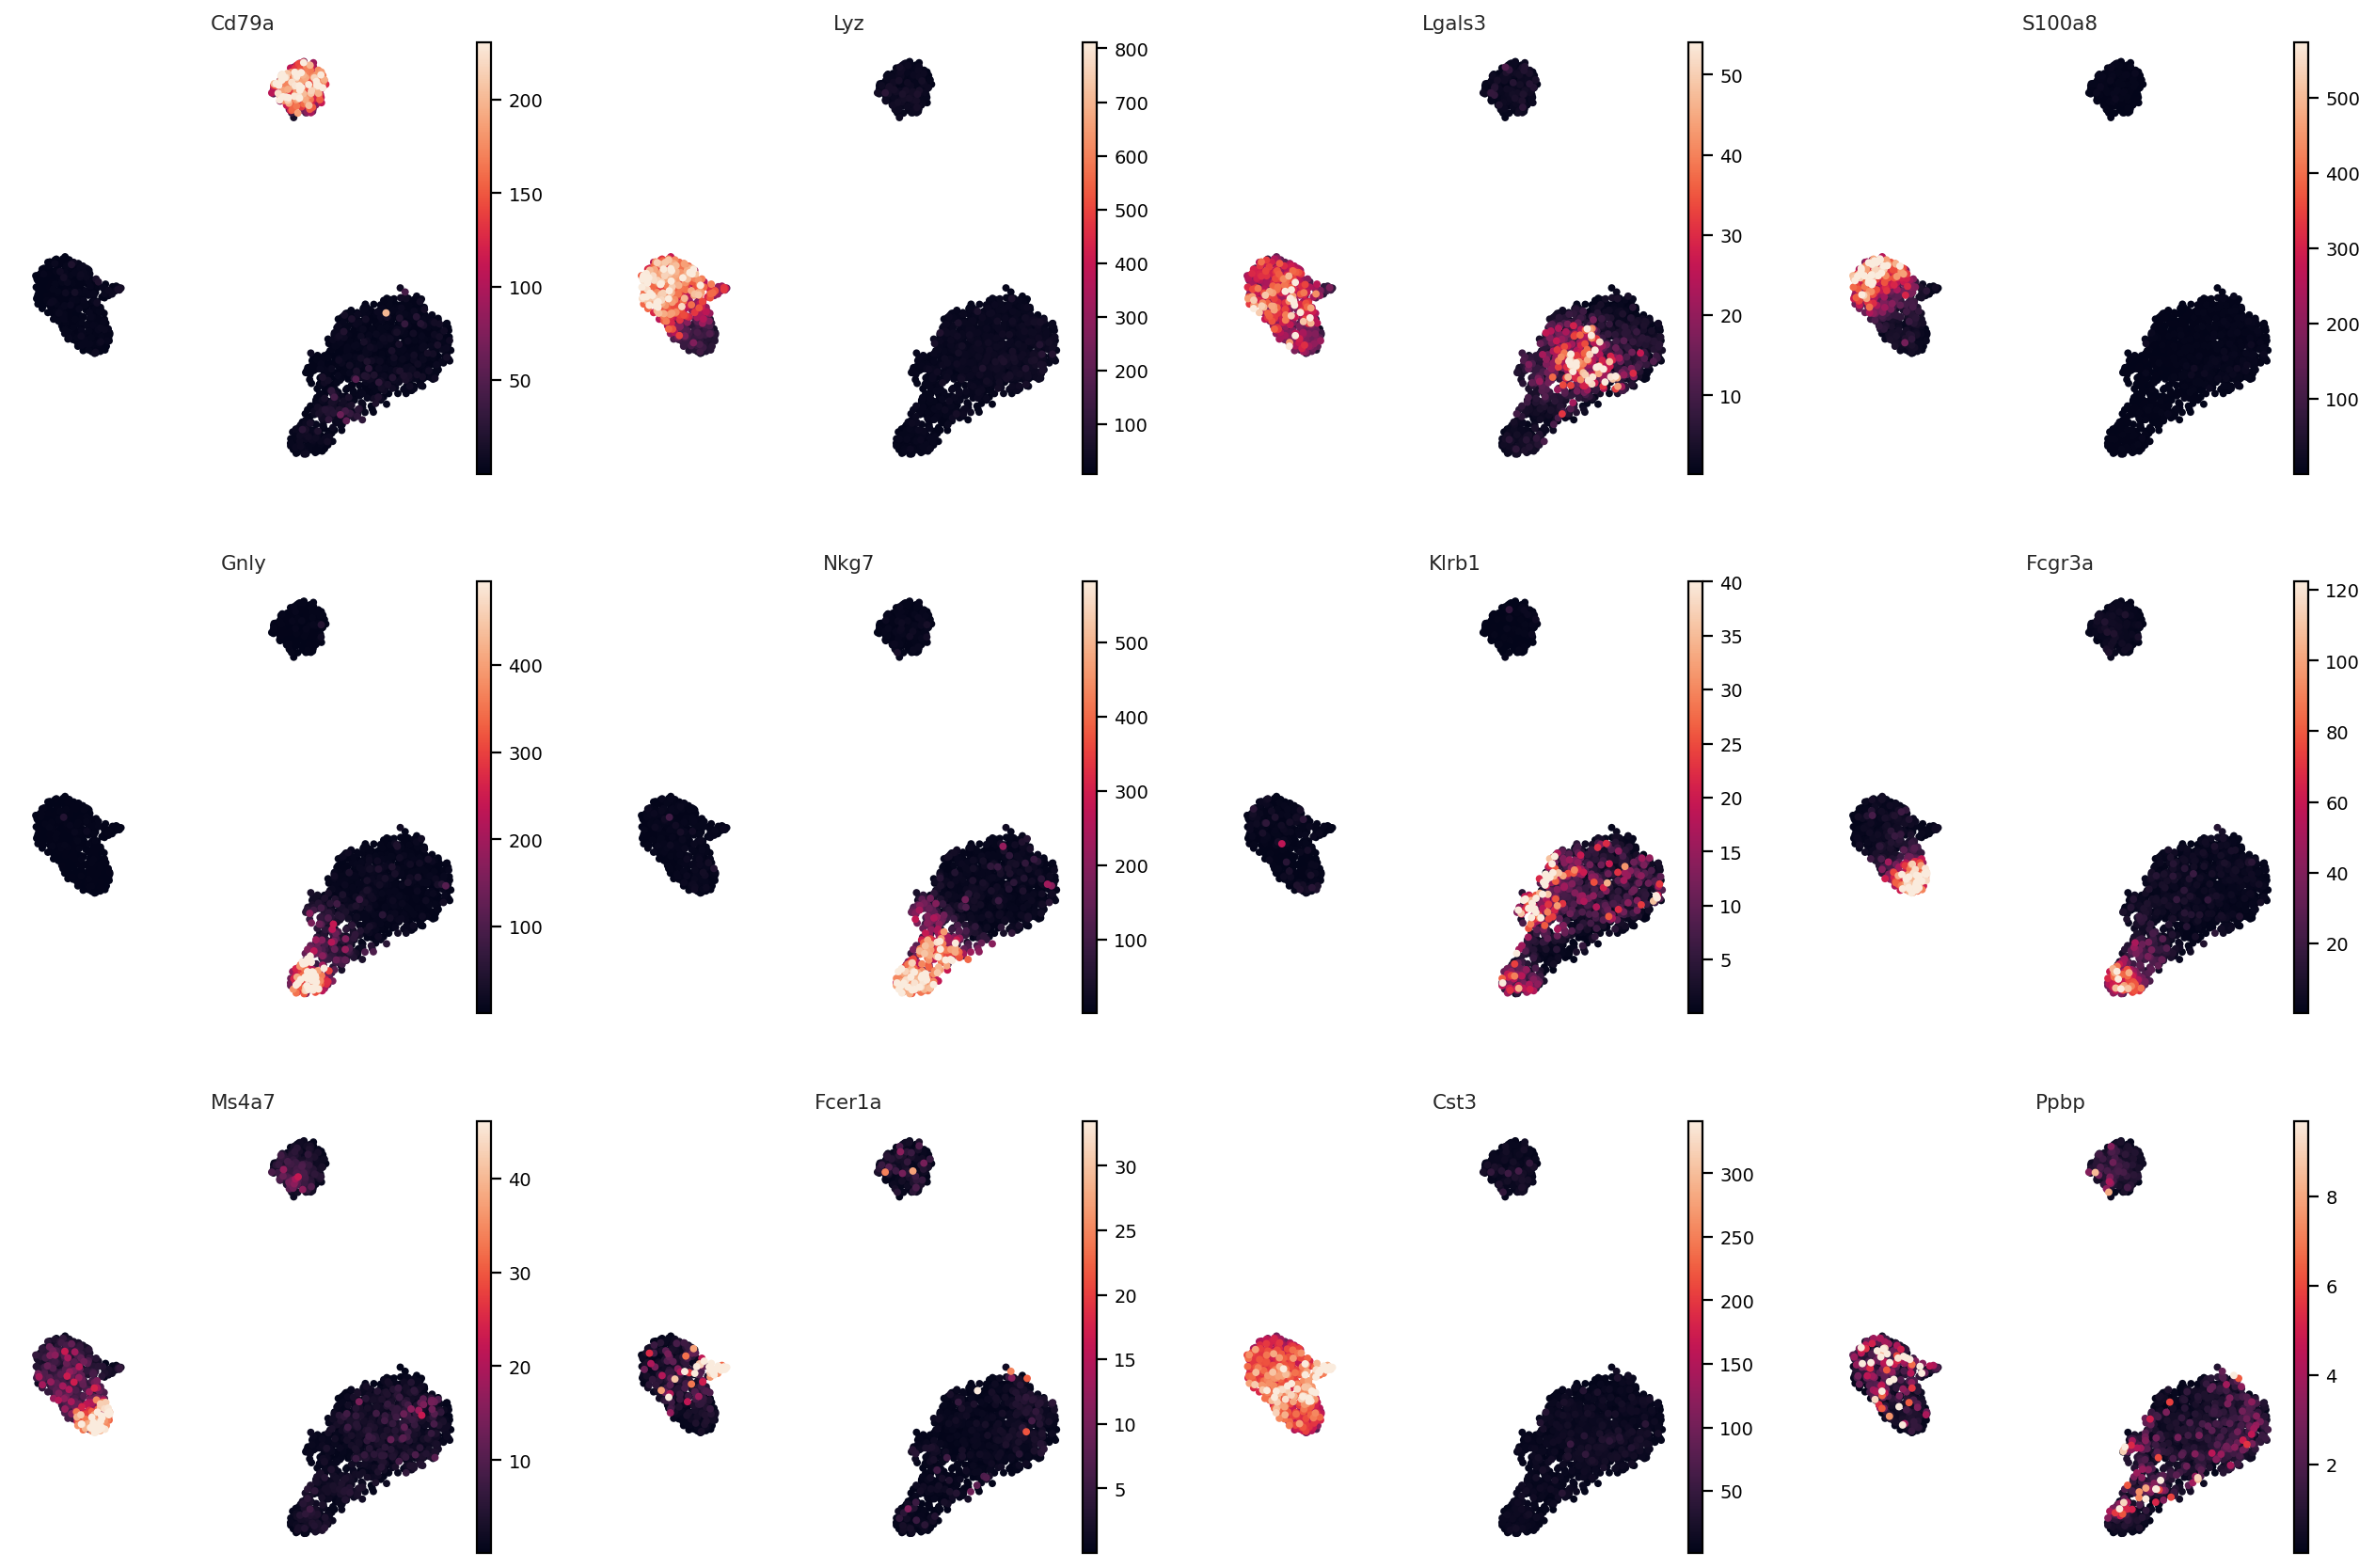

In [24]:
geneList = ["Cd79a", "Lyz", "Lgals3", "S100a8", "Gnly", "Nkg7", "Klrb1", "Fcgr3a", "Ms4a7", "Fcer1a", "Cst3", "Ppbp"]
sc.settings.figdir = "analysis"
# use rna.pl.gene_tsne() to use tsne latent rep instead
rna.pl.gene_umap(
    adata,
    geneList,
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    figsize = (4, 4), # size of each panel
    dpi = 80, # resolution of figure to show
    dpi_save = 300, # resolution of figure to save
    min_quantile = 0.01, # the quantile of expression for a gene to set the minimum of the colorbar to
    max_quantile = 0.99, # the quantile of expression for a gene to set the maximum of the colorbar to
    save="_marker_genes_scvi_expression.png"
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see scanpy documentation)
)

## Gene density plot

2022-07-18 22:05:50 - gene_density_plot - INFO: Saving figure to analysis/umap_marker_genes_density.png
INFO:gene_density_plot:Saving figure to analysis/umap_marker_genes_density.png


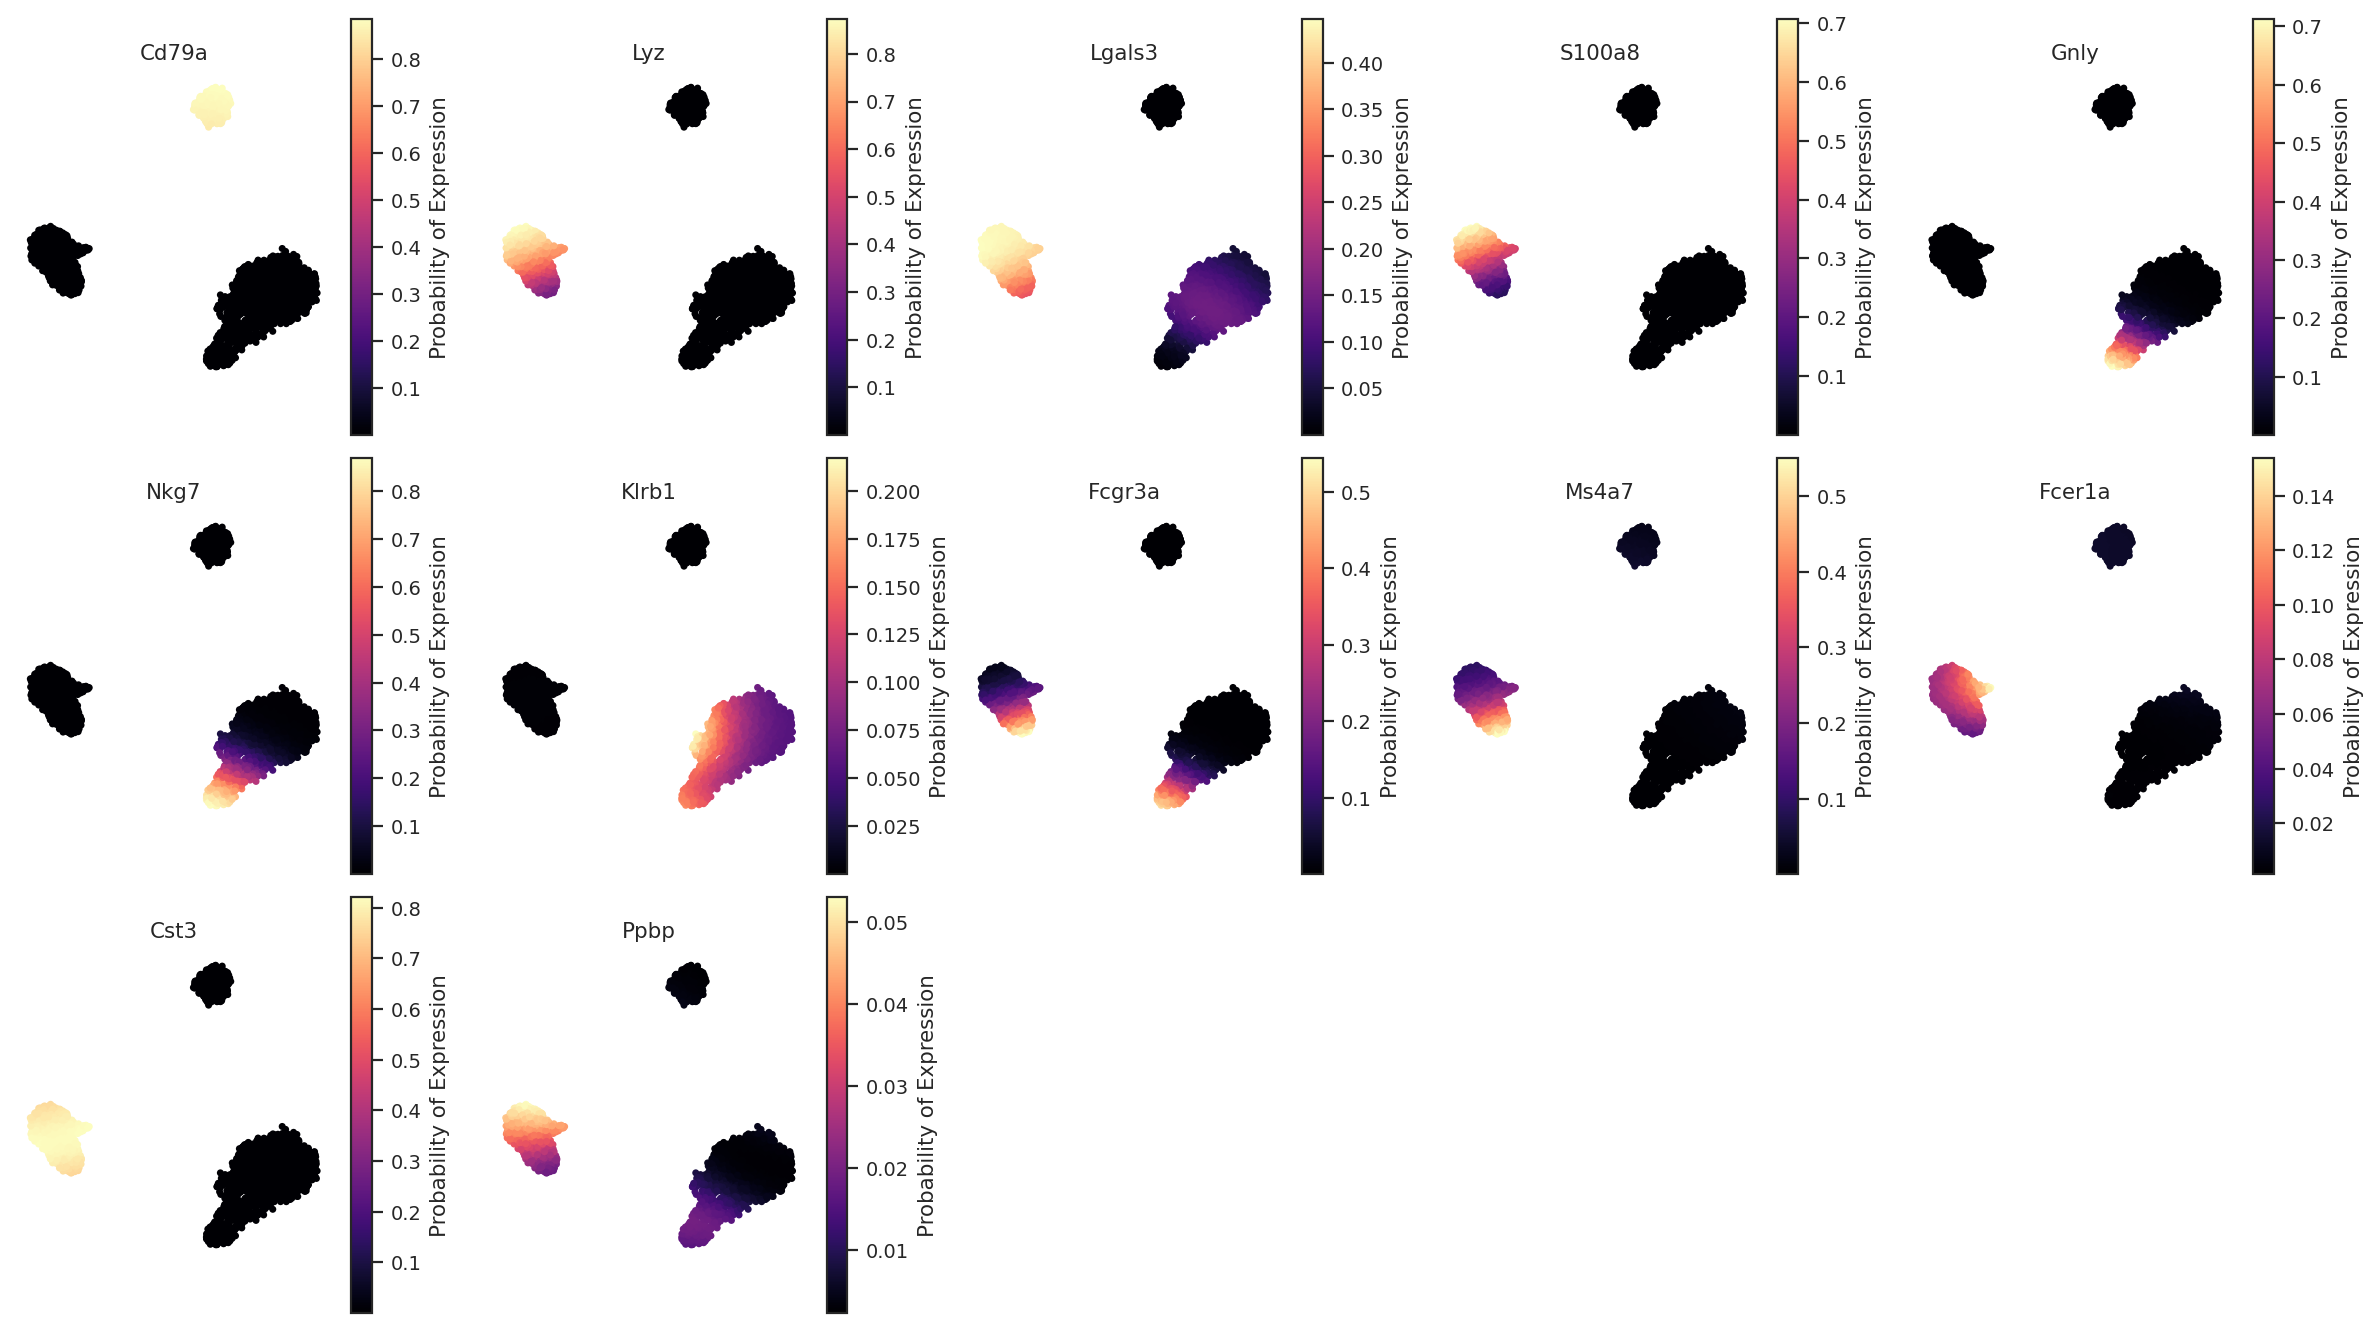

In [25]:
rna.pl.gene_density_plot(
        adata,
        geneList,
        data_loc="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
        latent_rep="X_umap", # The latent rep to calculate density over
        cmap="magma", # The colormap to use (see matplotlib.pyplot documentation for options)
        s=10, # Size of each data point
        ncols=5, # Number of columns in the figure
        figsize=(3, 3), # Size of each panel
        title=None,
        save_path="analysis/umap_marker_genes_density.png",
        dpi=300, # Resolution of saved figure
)

# Rename clusters to cell types

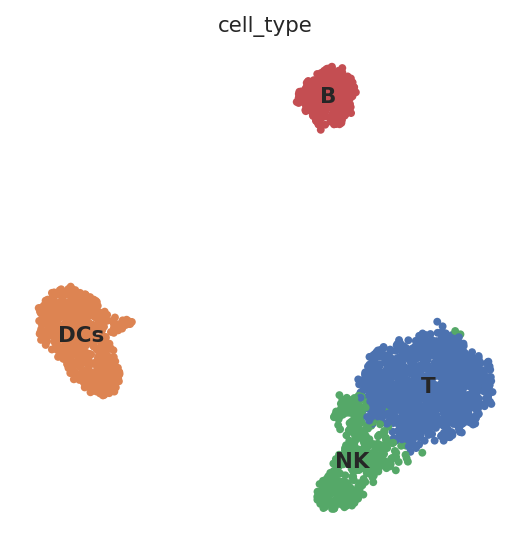

In [26]:
# Rename leiden clusters with corresponding cell types
cellTypes = {
    "0": "T",
    "1": "DCs",
    "2": "NK",
    "3": "B",
}
adata.obs["cell_type"] = adata.obs.leiden_scVI.replace(cellTypes)
sc.pl.umap(
    adata,
    color=["cell_type"],
    legend_loc="on data",
)

# Cluster DE marker genes

In [27]:
deGenes = rna.tl.cluster_de(
    adata,
    model, # Trained scVI model for the data
    cluster_key="cell_type", # cell type labels to calculate DE genes between
    lfc_mean_threshold=0, # Minimum LFC to consider a DE gene (default to only look at >0, i.e. genes with higher expression in a given cluster than everywhere else)
    bayes_factor_threshold=3, # Minimum bayes factor to consider a DE gene (see scVI documentation for explanation)
    non_zeroes_proportion_threshold=0.1, # Minimum proportion of cells with non-zero expression to consider a DE gene (removes stochastic noise/contamination)
    subset=True, # Whether to subset the DE gene list based on thresholds or return all genes in data
    save_path="analysis/DE", # Folder to save DE gene dataframes to
)

DE...: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


In [28]:
deGenes["B"].head(10)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Cd79a,0.9996,0.0004,7.823621,0.014897,0.000308,0.0,0.25,6.529129,6.484041,1.942895,...,4.501728,0.053912,0.951557,0.041985,143.075119,1.218789,True,B vs Rest,B,Rest
Cd79b,0.9988,0.0012,6.724225,0.009901,0.000533,0.0,0.25,4.518450,4.527617,1.330432,...,3.532868,0.202290,0.944637,0.143130,115.904915,3.808313,True,B vs Rest,B,Rest
Hla-dqb1,0.9972,0.0028,5.875328,0.008656,0.000562,0.0,0.25,4.673267,4.694515,1.649940,...,2.961934,0.308684,0.889273,0.154103,96.764397,4.075125,True,B vs Rest,B,Rest
Tcl1a,0.9970,0.0030,5.806135,0.007385,0.000156,0.0,0.25,6.183428,6.102442,2.252292,...,2.242213,0.026240,0.640138,0.021469,79.331558,0.602760,True,B vs Rest,B,Rest
Cd74,0.9946,0.0054,5.215940,0.078988,0.008381,0.0,0.25,3.543266,3.712052,1.027494,...,28.200687,5.655544,1.000000,0.833969,921.054749,84.357048,True,B vs Rest,B,Rest
Hla-dqa1,0.9946,0.0054,5.215940,0.009053,0.000690,0.0,0.25,4.901794,4.934078,1.947432,...,3.107263,0.358779,0.920415,0.122137,101.964729,4.137765,True,B vs Rest,B,Rest
Fcrla,0.9940,0.0060,5.109976,0.001417,0.000060,0.0,0.25,5.062055,5.011414,2.324777,...,0.477509,0.005725,0.314879,0.005725,15.775640,0.144084,True,B vs Rest,B,Rest
Hla-dra,0.9912,0.0088,4.724163,0.054464,0.005309,0.0,0.25,4.655579,5.105717,1.963700,...,18.989613,4.295789,1.000000,0.498569,615.017273,50.733696,True,B vs Rest,B,Rest
P2rx5,0.9908,0.0092,4.679308,0.001205,0.000082,0.0,0.25,4.551847,4.516313,2.193169,...,0.387543,0.020038,0.262976,0.019561,13.175281,0.529492,True,B vs Rest,B,Rest
Hla-dpb1,0.9888,0.0112,4.480577,0.024523,0.003243,0.0,0.25,3.818294,4.084167,1.615067,...,7.422139,2.204667,0.986159,0.455153,241.369232,29.144054,True,B vs Rest,B,Rest


# Cell type similarity

## Get immgen cell type signatures

In [29]:
# Download and load the immgen cell type signature data to a folder at save_path
immgen = rna.tl.get_immgen_similarity_signatures(save_path="data") 
immgen

,SC_LT34F_BM,SC_LTSL_BM,SC_STSL_BM,SC_LTSL_FL,SC_STSL_FL,SC_MPP34F_BM,SC_ST34F_BM,SC_CMP_BM,SC_MEP_BM,SC_GMP_BM,...,Ep_MEChi_Th,Fi_MTS15+_Th,Fi_Sk,FRC_MLN,FRC_SLN,LEC_MLN,LEC_SLN,BEC_MLN,BEC_SLN,St_31-38-44-_SLN
gene_name,,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,6.797117,6.360333,6.662006,6.427335,6.437454,6.679156,6.790981,6.943933,7.635508,7.117373,...,6.476976,6.609829,6.502716,6.731251,6.780717,6.816932,7.149442,6.942866,6.996807,6.529115
0610009L18Rik,7.316544,8.168883,7.861428,7.800822,7.507517,7.541081,7.455853,7.620293,7.114336,7.677924,...,7.996490,7.452834,7.537444,7.763949,7.545011,7.574276,7.177180,7.643272,7.463900,7.600032
0610010F05Rik,7.400632,7.056768,7.160870,7.381136,7.572367,7.270314,7.473560,7.626782,7.475628,6.164643,...,7.275631,6.908525,6.612712,5.439932,6.098217,6.716511,7.119968,6.492121,6.728206,6.356234
0610010K14Rik,9.246308,9.295594,8.917933,9.367240,9.247446,9.598990,9.599037,9.286498,9.292842,10.031798,...,8.417190,8.377814,9.693119,8.777117,8.631075,9.212467,9.399297,9.395945,9.408379,8.609123
0610038B21Rik,5.861660,6.171731,5.818086,6.296947,6.031117,6.096877,5.932255,6.636587,6.368213,6.342167,...,6.041710,5.763672,6.043463,6.192078,5.952597,5.838795,5.687346,6.040654,5.863289,6.197374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyx,9.272275,10.091382,10.290411,9.686166,9.693199,9.263065,9.275447,9.290837,7.203798,9.167604,...,7.627300,8.744558,9.711825,9.024311,8.776755,9.386212,9.366995,9.160313,9.040734,9.292802
Zzef1,8.120165,8.430231,8.487346,8.168742,8.455237,7.849267,8.083128,8.474797,8.285157,7.571358,...,7.780487,8.307825,7.919775,7.882258,8.075704,8.389248,8.321919,8.261564,8.307784,7.852217
Zzz3,9.536164,9.641560,9.469255,9.798141,9.703494,9.309358,9.564820,9.540835,9.438682,7.894254,...,8.883996,9.326355,8.868233,8.466615,8.921892,8.794250,9.027696,8.824545,8.883593,8.514935


## Cosine similarity to immgen cell types

In [30]:
# Cell type similarity scores for each cell are added as columns to adata.obs
adata=rna.tl.cell_type_similarity(
    adata,
    signatures=immgen, # The gene x cell type DataFrame containing cell type signatures for scoring
)
# Each column is named (cell_type)_cosine_similarity_cell_z_score

2022-07-18 22:05:58 - cell_type_similarity - INFO: Scaling cosine similarity scores to z-scores by cell
INFO:cell_type_similarity:Scaling cosine similarity scores to z-scores by cell


In [31]:
# List all similarity scores
[i for i in adata.obs.columns if "cosine_similarity" in i]

['SC_LT34F_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_BM_cosine_similarity_cell_z_score',
 'SC_STSL_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_FL_cosine_similarity_cell_z_score',
 'SC_STSL_FL_cosine_similarity_cell_z_score',
 'SC_MPP34F_BM_cosine_similarity_cell_z_score',
 'SC_ST34F_BM_cosine_similarity_cell_z_score',
 'SC_CMP_BM_cosine_similarity_cell_z_score',
 'SC_MEP_BM_cosine_similarity_cell_z_score',
 'SC_GMP_BM_cosine_similarity_cell_z_score',
 'SC_CDP_BM_cosine_similarity_cell_z_score',
 'SC_MDP_BM_cosine_similarity_cell_z_score',
 'MLP_BM_cosine_similarity_cell_z_score',
 'MLP_FL_cosine_similarity_cell_z_score',
 'proB_CLP_BM_cosine_similarity_cell_z_score',
 'proB_FrA_BM_cosine_similarity_cell_z_score',
 'proB_FrBC_BM_cosine_similarity_cell_z_score',
 'preB_FrC_BM_cosine_similarity_cell_z_score',
 'preB_FrD_BM_cosine_similarity_cell_z_score',
 'B_FrE_BM_cosine_similarity_cell_z_score',
 'proB_CLP_FL_cosine_similarity_cell_z_score',
 'proB_FrA_FL_cosine_similarity_cell_z

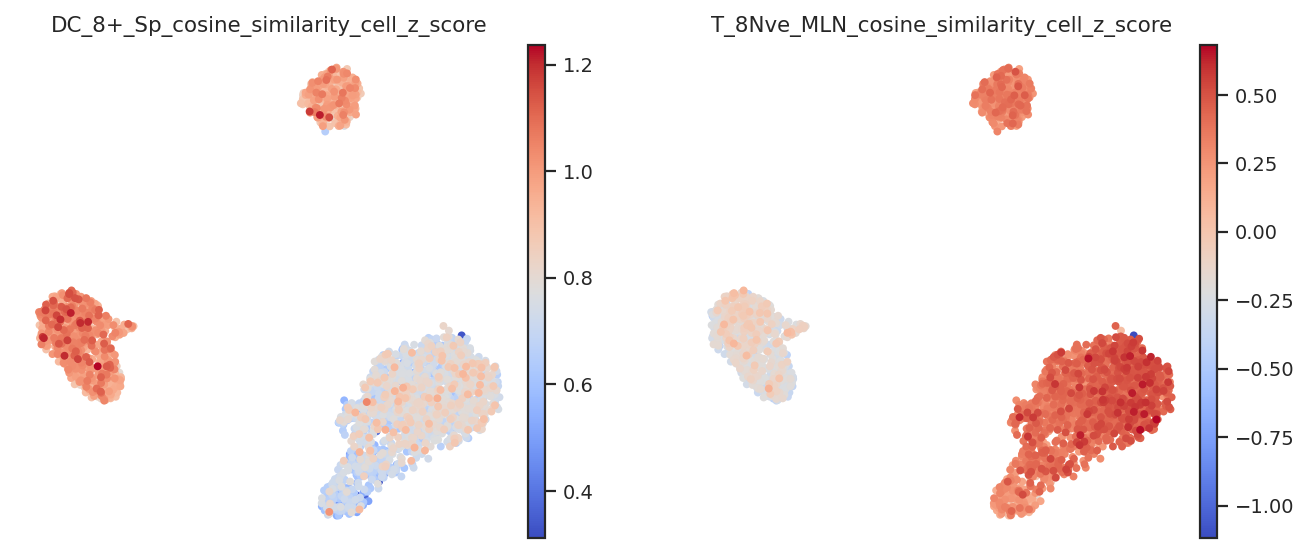

In [32]:
# Plot selected similarity scores
sc.pl.umap(
    adata,
    color=["DC_8+_Sp_cosine_similarity_cell_z_score", "T_8Nve_MLN_cosine_similarity_cell_z_score"],
    cmap="coolwarm",
)

## Create a new signature file for similarity scoring using this data

In [4]:
# Pseudobulk a single cell datset by cell type to create new cell type signatures for scoring
rna.tl.create_cell_type_signature(
    adata,
    save_path="analysis/pbmc3k_cell_type_signature.csv", # The path to save the signature to
    cell_type_labels="cell_type", # The column in adata.obs that contains cell type annotations
    data_loc="raw", # The location of expression data to use (must be cell size normalized and log-transformed counts).
                    # By default this uses the raw attribute, which in this pipeline contains ALL genes in the dataset,
                    # But the subset of genes within adata.X or a layer could be used as long as the expression data is 
                    # log-transformed counts.
)

ValueError: Length of values (1) does not match length of index (16575)

In [12]:
adata.X.mean(axis=0)

array([-4.6983955e-09, -9.7224739e-04,  7.1225674e-09, ...,
        4.0861048e-09, -3.3988392e-09,  6.9101400e-09], dtype=float32)

In [11]:
import numpy as np
np.array(adata.raw.to_adata().X.todense()).mean(axis=0)

array([0.00600996, 0.00204259, 0.00241588, ..., 0.00075887, 0.07046793,
       0.04300654], dtype=float32)

# Differential density

In [34]:
# Create fake condition/control groups
random.seed(0)
adata.obs["genotype"] = [bool(random.getrandbits(1)) for i in range(0,len(adata))]
adata.obs.genotype = adata.obs.genotype.replace({True: "KO", False: "WT"})

In [35]:
adata = rna.tl.log_density_ratio(
    adata,
    group_by="genotype", # The column in adata.obs containing condition/control labels
    groups=["KO", "WT"], # The condition/control labels in adata.obs[group_by] to use
    latent_rep="X_umap", # The latent representation to calculate density over
    key_added="KO/WT_log_density_ratio", # The column to add to adta.obs with the differential density ratio
)

2022-07-18 22:05:59 - log_density_ratio - INFO: Calculating log density ratio of WT/KO
INFO:log_density_ratio:Calculating log density ratio of WT/KO


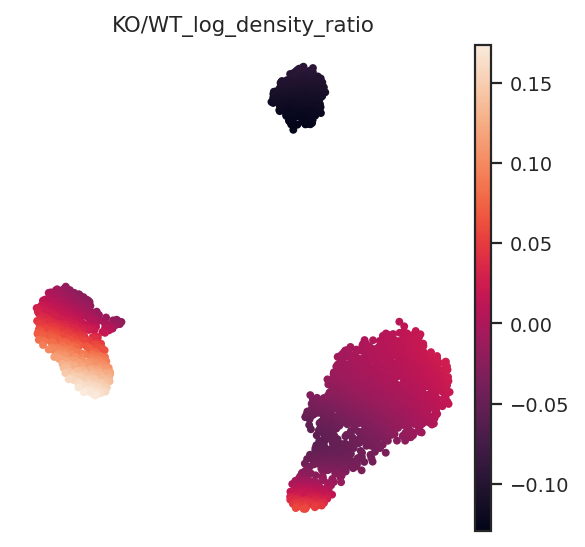

In [36]:
sc.pl.umap(
    adata,
    color="KO/WT_log_density_ratio",
)
# As expected there is not significant enrichment of either randomly assigned genotype in a particular region on the UMAP (note the colorbar scale)

# Save anndata

In [37]:
adata.write("data/pbmc_3k_1200_hvgs.h5ad")

# Other tools

## Get expression matrix

In [38]:
# Returns a cell x gene DataFrame with expression data from 'adata.X' 'adata.raw' or a layer in 'adata.layers'
data = rna.tl.get_expression_matrix(
    adata,
    "scVI_normalized", # Can be 'X', 'raw', or a layer in 'adata.layers'
)
data.index=adata.obs.index
data.columns=adata.var_names
data

,Isg15,Cpsf3l,Rer1,Lrrc47,Tnfrsf25,Tnfrsf9,Rbp7,Srm,Ubiad1,Prdm2,...,Ttc3,Dscr3,Brwd1,Mx1,C21orf33,Icoslg,Sumo3,S100b,Mt-co2,Mt-nd6
index,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,8.392061,0.453146,3.979614,1.346016,14.642024,0.313931,0.051333,5.034274,1.830897,2.124619,...,3.921450,0.525181,1.536733,5.610405,3.551764,0.009191,0.803932,3.144233,186.434631,6.027479
AAACATTGAGCTAC-1,14.227058,24.674776,9.433458,2.331986,0.018595,0.024149,0.242799,2.914865,0.323453,3.922216,...,2.014461,4.517710,2.740328,10.741565,9.692370,0.075765,2.616259,1.745111,195.940475,0.204305
AAACATTGATCAGC-1,22.037384,2.827790,16.070286,2.144936,2.657873,0.038132,4.086515,11.952968,0.961760,3.093091,...,6.493499,1.523875,2.120829,8.117714,7.134422,2.559069,6.200565,11.944637,185.945786,6.400345
AAACCGTGCTTCCG-1,85.594002,2.759548,5.321434,0.351603,0.615785,0.062992,0.658835,2.033873,0.065962,0.467921,...,5.896930,1.308709,1.017860,12.887342,0.980717,1.301404,3.186837,0.240912,140.782425,5.180233
AAACGCACTGGTAC-1,10.238775,1.691215,13.040669,0.276300,0.516708,0.064880,1.867780,14.735142,54.136700,1.860025,...,5.780711,1.337775,1.500927,2.930603,1.467710,31.921610,1.652459,0.251492,168.562469,0.642190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACACCTGA-1,52.748627,4.531271,6.341697,2.517783,1.441801,1.081969,0.580718,4.857732,0.521066,1.037354,...,2.923667,1.240650,1.831864,21.163301,2.177011,2.783763,8.754247,0.430150,110.659531,17.719398
TTTCGAACTCTCAT-1,89.143028,2.676251,3.072466,0.576648,1.345384,0.332018,0.659847,1.085896,0.039508,0.141616,...,0.788944,0.934621,0.604950,15.080908,1.898892,2.321899,2.635034,0.053766,74.116730,18.516390
TTTCTACTGAGGCA-1,27.831776,6.668286,6.296886,21.093845,3.455725,0.001867,0.111932,4.116823,0.802039,9.852734,...,3.656948,3.466775,1.758023,10.219090,7.271220,0.291642,3.522232,2.076387,133.106705,0.834129
